# MetaCost
Autorzy:
- Piotr Hondra
- Jan Jeschke

Opis zadania: 

Zintegrowane uwzględnianie kosztów pomyłek przy tworzeniu modeli klasyfikacji przez próbkowanie przykładów klas o niskich kosztach pomyłek, replikację przykładów klas o wysokich kosztach pomyłek oraz zmianę etykiet (metoda MetaCost). Implementacja w formie opakowania umożliwiającego użycie dowolnego algorytmu klasyfikacji dostępnego w środowisku R lub Python stosującego standardowy interfejs wywołania. Funkcje do tworzenia modelu i predykcji. Badanie wpływu uwzględniania kosztów pomyłek na jakość modeli klasyfikacji tworzonych za pomocą wybranych algorytmów dostępnych w środowisku R lub Python.

## Założenia wstępne


## Opis implementacji
Algorytm MetaCost został zaimplementowany w formie klasy `MetaCost`. Klasa jest inicjalizowana parametrami algorytmu MetaCost oraz modelem, który zawiera metody `.fit()`, `.predict()` w szczególności pochodzi z biblioteki `scikit learn`.

Podstawowe wywołanie algorytmu polega na wywołaniu:
```python
model = MetaCost(
    model=metacost_model,
    m=10,
    n=num_examples // 10,
    num_classes=num_classes,
    p=False,
    q=False,
    C=cost_matrix,
)
fitted_model = model.fit(X_train, y_train)
```

Metoda fit wykonuję dwa zasadnicze kroki:
- wywołuję zmianę etykiet na podstawie podanych parametrów algorytmu (metoda `_y_relabel()`)
- na nowych etykietach przeprowadzane jest uczenie

Pierwszym krokiem algorytmu jest metacost (`_y_relabel()`) jest generacja `m` modeli uczonych na `n` przykładach pochodzących z zbioru treningowego. W szczególności `n` moze być równe wszystkim przykładom w zbiorze treningowym. Ważne jest aby za każdym razem tworzyć nowy model poprzrz kopię (`sklearn.base.clone()`), aby uniknąć powtórnego trenowania modelu, co byłoby błędem.

Kolejnym etapem jest wybór modeli biorących udział w głosowaniu. Możemy skorzystać ze wszystkich modeli lub wyłącznie modeli na których, algorytm nie był trenowany. Decyduje o tym paramter `q`. Następnie wyliczane jest prawdopodobieństwo  $P(c|x)$ wystąpienia klasy $c$ ze zbioru zbioru wszystkich możliwych klas $C$ pod warunkiem wystąpienia przykładu trenujacego $x, x\in X_{train}$




## Eksperymenty

W celu udowodnienia postawionych hipotez badawczych przeprowadzono wiele eksperymentów zawierających różne zbiory danych (wine quality, Adults, bank marketing) oraz modele klasyfikacji (drzewo decyzyjne, perceptron wielowarstwowy, naiwiny klasyfikator bayesowski oraz las losowy).

### Opis zbiorów danych

Wszystkie zbiory danych pochodzą z UCI Machine Learning Repository.

- **Wine Qulaity** to zbiór danych Wine Quality składa się z dwóch zestawów danych dotyczących czerwonych i białych odmian portugalskiego wina "Vinho Verde". W zestawach danych nie ma brakujących wartości, co ułatwia ich analizę. Klasyfikacja jakości win jest uporządkowana i niezrównoważona, co oznacza, że w zbiorze jest znacznie więcej win o przeciętnej jakości niż doskonałych lub bardzo słabych.
- Zbiór danych **Adults**, znany również jako "Census Income" dataset, służy do przewidywania, czy dochód osoby przekracza 50 tysięcy dolarów rocznie na podstawie danych zebranych w spisie ludności. W zbiorze występowały brakujące wartości, jednakże było ich na tyle mało, że zostały usunięte przed rozpoczęciem analizy.
- **Bank Marketing** dotyczy kampanii marketingowych bezpośrednich portugalskiej instytucji bankowej, które były przeprowadzane za pomocą rozmów telefonicznych. Często wymagane było więcej niż jeden kontakt z tym samym klientem, aby ocenić, czy produkt (lokata terminowa) zostanie przez niego subskrybowany ('yes') lub nie ('no'). Zbiór danych zawiera informacje na temat różnych cech kampanii oraz odpowiedzi klientów.


In [21]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

datasets = {
    "wine_quality": fetch_ucirepo(id=186),
    "adults": fetch_ucirepo(id=2),
    "bank_marketing": fetch_ucirepo(id=222),
}
datasets["adults"].data.targets.loc[:, "income"] = (
    datasets["adults"].data.targets["income"].str.replace(".", "")
)

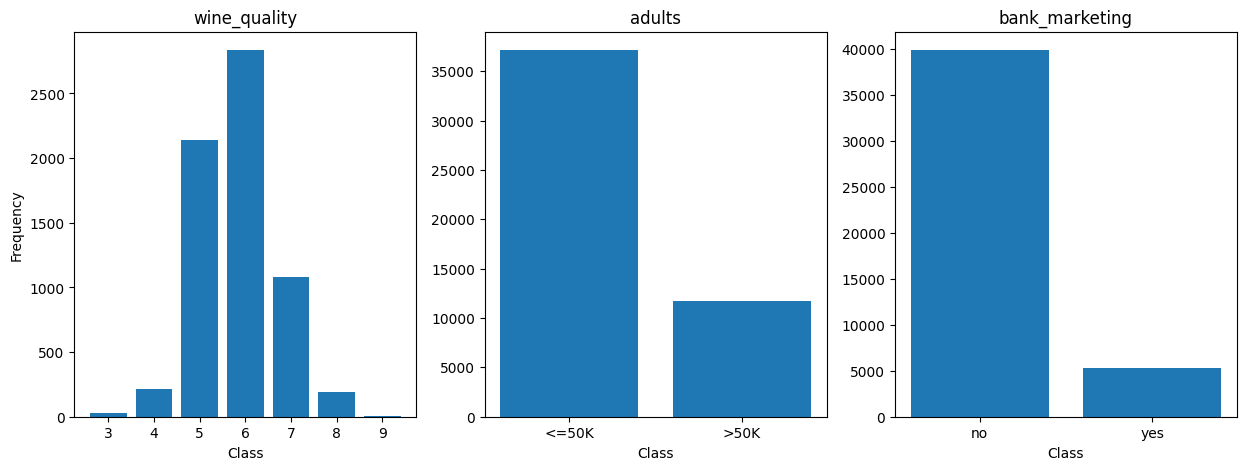

In [22]:
import collections
from itertools import product

fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5))
for (i, ax), (dataset_name, dataset) in zip(enumerate(axes), datasets.items()):
    class_distribution = collections.Counter(dataset.data.targets.values.ravel())

    # Plotting the histogram in the corresponding subplot
    ax.bar(class_distribution.keys(), class_distribution.values())

    ax.set_xlabel("Class")
    if i == 0:
        ax.set_ylabel("Frequency")
    ax.set_title(f"{dataset_name}")

## Przygotowanie zbiorów danych

Zbiory danych zawierają zarówno wartosci ciągłe jak i dyskretne. Aby umożliwić wszystkim algorytmom poprawne działanie zastosowano wstępne przetworzenie danych. W pierwszej kolejności usunieto przykłady z wartościami brakującymi, ponieważ stanowiły niewielki odsetek całego zbioru danych, w szczególności nie występowały. Kolejnym krokiem było zakodowanie dyskretnych danych poprzez *One Hot Encoding* oraz normalizacja danych ciągłych do rozkładu normalnego. Przetwarzaniem oraz 

# Eksperymenty

Badanie własności algorytmu wyłącznie na zbiorze wine_quality używając drzewa decyzyjnego. Sprawdzono różne wartości parametrów, takich jak ilość prób do wygenerowania $m$, $m\in\{10,20,30\}$, oraz ilości próbek w każdej wygenerowanej próbie $n$, $n\in \{s,\frac{}{10}, \frac{s}{100}\,|\, s=|X_{train}|\}$

W eksperymencie każde $C(i,i)$ zostało wybrane losowo z rozkładem jednostajnym w przedziale $[0, 1000]$, a każde $C(i,j)$ dla $i \neq j$ zostało wybrane z jednostajnym prawdopodobieństwem z przedziału $[0, 2000 \cdot P(i,j)]$, gdzie $P(i)$ i $P(j)$ to prawdopodobieństwa wystąpienia klasy $i$ i $j$ odpowiednio w zbiorze treningowym. Zatem wartość oczekiwana $C(i,j)$ wynosiła $1000 \cdot \frac{P(i)}{P(j)}$. Oznacza to, że najwyższe koszty ponoszone są przy błędnym sklasyfikowaniu rzadkiej klasy jako często występującej i analogicznie najniższe koszty występują przy odwrotnym przypadku.

W kolejnym eksperymencie tak samo jako poprzednio zainicjalizowano macierz kosztów jednostajnie z prawdopodobieństwem z przedziału $[0, 2000 \cdot P(i,j)]$. Jednak w tym przypadku $C(i,i)$ zostało zainicjalizowane na 0.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(action="ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
from src.data import DataFactory
from ucimlrepo import fetch_ucirepo

RANDOM_STATE = 42

classifiers = {
    "decision_tree": DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    "mlp": MLPClassifier(max_iter=100, random_state=RANDOM_STATE),
    "naive_bayes": GaussianNB(),
    "random_forest": RandomForestClassifier(
        max_depth=20, n_estimators=20, random_state=RANDOM_STATE
    ),
}

datasets = {
    "wine_quality": fetch_ucirepo(id=186),
    "adults": fetch_ucirepo(id=2),
    "bank_marketing": fetch_ucirepo(id=222),
}


data_factory = DataFactory(datasets, random_state=RANDOM_STATE)

### Pokazanie, że działa tak jak w publikacji

In [4]:
from src.experiments import run_exps
from src.cost_functions import *

results = run_exps(random_cost, data_factory, classifiers)

Processing..:   0%|          | 0/12 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   8%|▊         | 1/12 [00:07<01:26,  7.82s/it]

Dataset: wine_quality, Classifier: mlp


Processing..:  17%|█▋        | 2/12 [00:19<01:42, 10.28s/it]

Dataset: wine_quality, Classifier: naive_bayes


Processing..:  25%|██▌       | 3/12 [00:32<01:40, 11.20s/it]

Dataset: wine_quality, Classifier: random_forest


Processing..:  33%|███▎      | 4/12 [01:31<04:00, 30.03s/it]

Dataset: adults, Classifier: decision_tree


Processing..:  42%|████▏     | 5/12 [02:20<04:19, 37.12s/it]

Dataset: adults, Classifier: mlp


Processing..:  50%|█████     | 6/12 [04:24<06:39, 66.65s/it]

Dataset: adults, Classifier: naive_bayes


Processing..:  58%|█████▊    | 7/12 [05:28<05:28, 65.63s/it]

Dataset: adults, Classifier: random_forest


Processing..:  67%|██████▋   | 8/12 [13:11<12:49, 192.32s/it]

Dataset: bank_marketing, Classifier: decision_tree


Processing..:  75%|███████▌  | 9/12 [14:04<07:25, 148.58s/it]

Dataset: bank_marketing, Classifier: mlp


Processing..:  83%|████████▎ | 10/12 [15:44<04:27, 133.54s/it]

Dataset: bank_marketing, Classifier: naive_bayes


Processing..:  92%|█████████▏| 11/12 [16:52<01:53, 113.62s/it]

Dataset: bank_marketing, Classifier: random_forest


Processing..: 100%|██████████| 12/12 [25:02<00:00, 125.21s/it]


In [5]:
results = run_exps(proportional_to_occurrence, data_factory, classifiers)

Processing..:   0%|          | 0/12 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   8%|▊         | 1/12 [00:06<01:14,  6.81s/it]

Dataset: wine_quality, Classifier: mlp


Processing..:  17%|█▋        | 2/12 [00:21<01:56, 11.67s/it]

Dataset: wine_quality, Classifier: naive_bayes


Processing..:  25%|██▌       | 3/12 [00:39<02:10, 14.47s/it]

Dataset: wine_quality, Classifier: random_forest


Processing..:  33%|███▎      | 4/12 [01:49<04:49, 36.23s/it]

Dataset: adults, Classifier: decision_tree


Processing..:  42%|████▏     | 5/12 [02:50<05:16, 45.21s/it]

Dataset: adults, Classifier: mlp


Processing..:  50%|█████     | 6/12 [05:17<07:58, 79.82s/it]

Dataset: adults, Classifier: naive_bayes


Processing..:  58%|█████▊    | 7/12 [06:29<06:25, 77.14s/it]

Dataset: adults, Classifier: random_forest


Processing..:  67%|██████▋   | 8/12 [15:28<14:57, 224.26s/it]

Dataset: bank_marketing, Classifier: decision_tree


Processing..:  75%|███████▌  | 9/12 [16:25<08:35, 171.93s/it]

Dataset: bank_marketing, Classifier: mlp


Processing..:  83%|████████▎ | 10/12 [18:04<04:58, 149.38s/it]

Dataset: bank_marketing, Classifier: naive_bayes


Processing..:  92%|█████████▏| 11/12 [18:55<01:59, 119.54s/it]

Dataset: bank_marketing, Classifier: random_forest


Processing..: 100%|██████████| 12/12 [25:25<00:00, 127.16s/it]


In [10]:
ms = [10, 20, 30]
n_ratios = [1, 10, 100]
filtered_classifiers = {"decision_tree": classifiers["decision_tree"]}

filtered_datasets = {"wine_quality": datasets["wine_quality"]}

filtered_data_factory = DataFactory(filtered_datasets, random_state=RANDOM_STATE)


for m, n_ratio in product(ms, n_ratios):
    save_name = f"propotional_m={m}_nr={n_ratio}"
    run_exps(
        proportional_to_occurrence,
        filtered_data_factory,
        filtered_classifiers,
        m,
        n_ratio,
        save_name=save_name,
    )

Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset: wine_quality, Classifier: decision_tree


Processing..: 100%|██████████| 1/1 [00:24<00:00, 24.92s/it]


In [ ]:
# results = run_exps(zeros_on_diag, data_factory, classifiers)

# Wyniki

In [ ]:
from pathlib import Path
import pickle
from src.utils import create_df
import pandas as pd

root = Path("checkpoints")

In [ ]:
dfs = []
for m, n_ratio in product(ms, n_ratios):
    save_name = root / f"propotional_m={m}_nr={n_ratio}"
    with open(f"{save_name}.pkl", "rb") as f:
        pkl = pickle.load(f)

    df = create_df(pkl)
    df["m"] = m
    df["n_ratio"] = n_ratio

    dfs.append(df)

In [23]:
final_df = pd.concat(dfs, ignore_index=True)
final_df = final_df[final_df.is_metacost == "metacost"]
pivot_df = final_df.pivot_table(
    index=["m"],
    columns=["n_ratio"],
    values=["sum", "time"],
)

pivot_df["sum"] = pivot_df["sum"] / pivot_df["sum"].max().max()
pivot_df["time"] = pivot_df["time"] / pivot_df["time"].max().max()

pivot_df_formatted = pivot_df.map("{:.3f}".format)
pivot_df_formatted

sum                 time              
n_ratio    1      10     100    1      10     100
m                                                
10       1.000  0.835  0.883  0.338  0.309  0.337
20       0.848  0.768  0.779  0.775  0.611  0.530
30       0.997  0.739  0.807  0.958  0.776  1.000

W powyższej tabeli przedstawiono znormalizowaną sumę kosztów oraz znormalizowany czas dla różnych wartości $m$ oraz $n$, gdzie $n=\frac{s}{n\_ratio}$. Normalizacja polega na wybraniu maksymalnej wartości i podzielenie przez nią wszystkie wartości dotyczące danej metryki. Zatem normlaizacja obejmuje **całą tabelę** w zakresie metryki

Generalnie wraz ze wzrostem liczby prób $m$ otrzymuje się coraz lepsze wyniki. Co ciekawe w przypadku ilości próbek w próbie, dla $n\_ratio=10$ otrzymuje się optymalne wyniki, a nie dla $n\_ratio=1$. Wynika to z faktu, iż zmniejszając liczbę prób o 10 w stosunku do wielkości próby pierwotnej, algorytm jest bardziej odporny na szum. Jednakże ustawienie za małej ilości próbek ($n\_ratio=100$) skutkuje uzyskaniem gorszych rezultatów.

Warto zauważyć, że zwiększanie ilości prób $m$ znacząco bardziej wpływa na czas wykonywania algorytmu niż dobór ilości przykładów $n$. Optymalne pod względem zarówno jakości jak i czasu okazuje się ustawienie $m=10$, $n=\frac{s}{10}$.

In [15]:
with open(root / "random_cost.pkl", "rb") as f:
    random_diag = pickle.load(f)

random_cost_df = create_df(random_diag)
pivot_df = random_cost_df.pivot_table(
    index=["algorithm", "is_metacost"],
    columns="dataset",
    #   values=['balanced_accuracy', 'f1', 'precision', 'recall', 'sum'])
    values=["sum"],
)

pivot_df = pivot_df.swaplevel(axis=1).sort_index(axis=1, level=0)
# pivot_df["sum"] = pivot_df["sum"].apply(lambda x: x / x.max(), axis=0)
for dataset in pivot_df.columns.levels[0]:
    pivot_df[dataset, "sum"] = pivot_df[dataset, "sum"] / pivot_df[dataset, "sum"].max()

pivot_df_formatted = pivot_df.map("{:.3f}".format)
pivot_df_formatted

dataset                   adults bank_marketing wine_quality
                             sum            sum          sum
algorithm     is_metacost                                   
decision_tree baseline     0.328          0.547        0.722
              metacost     0.326          0.240        0.333
mlp           baseline     0.218          0.181        0.429
              metacost     0.150          0.139        0.340
naive_bayes   baseline     1.000          0.404        1.000
              metacost     0.158          1.000        0.379
random_forest baseline     0.160          0.338        0.343
              metacost     0.110          0.252        0.304

W powyższej tabeli przedstawiono znormalizowane sumy dla rozważanych zbiorów danych i algorytmów. Każdy algorytm porównano z oraz bez zastosowania algorytmu metacost, o czym świadycz odpowiednio *metacost* albo *baseline*. Normalizacja obejmuje podział wszystkich wartości przez maksymalną w **danym zbiorze danych**, a więc w kolumnach.

Widać, że zgodnie z oczekiwaniami algorytm uzyskuje najmniejsze sumy kosztów w zdecydowanej większości przypadków. Jedynym odstępstwem od reguły wyróżnia się zastosowanie naiwnego klasyfikatora bayesowskiego dla zbioru bank marketing.

In [ ]:
with open(root / "proportional_to_occurrence.pkl", "rb") as f:
    proportional_to_occurrence = pickle.load(f)
proportional_to_occurrence_df = create_df(proportional_to_occurrence)


pivot_df = proportional_to_occurrence_df.pivot_table(
    index=["algorithm", "is_metacost"],
    columns="dataset",
    values=["balanced_accuracy", "f1", "precision", "recall", "sum"],
)
#     values=["sum"],
# )

pivot_df = pivot_df.swaplevel(axis=1).sort_index(axis=1, level=0)
# pivot_df["sum"] = pivot_df["sum"].apply(lambda x: x / x.max(), axis=0)
for dataset in pivot_df.columns.levels[0]:
    pivot_df[dataset, "sum"] = pivot_df[dataset, "sum"] / pivot_df[dataset, "sum"].max()

pivot_df_formatted = pivot_df.map("{:.3f}".format)
pivot_df_formatted

dataset                              adults                                 \
                          balanced_accuracy     f1 precision recall    sum   
algorithm     is_metacost                                                    
decision_tree baseline                0.766  0.837     0.835  0.839  0.141   
              metacost                0.609  0.761     0.839  0.810  0.037   
mlp           baseline                0.774  0.846     0.844  0.849  0.125   
              metacost                0.656  0.794     0.833  0.826  0.050   
naive_bayes   baseline                0.737  0.666     0.821  0.642  0.609   
              metacost                0.580  0.414     0.741  0.418  1.000   
random_forest baseline                0.759  0.849     0.852  0.858  0.087   
              metacost                0.639  0.783     0.835  0.821  0.044   

dataset                      bank_marketing                                 \
                          balanced_accuracy     f1 precision recall    sum   
algorithm     is_metacost                                                    
decision_tree baseline                0.710  0.882     0.880  0.884  0.142   
              metacost                0.506  0.826     0.855  0.880  0.007   
mlp           baseline                0.748  0.902     0.900  0.905  0.107   
              metacost                0.547  0.848     0.880  0.888  0.012   
naive_bayes   baseline                0.703  0.854     0.866  0.846  0.254   
              metacost                0.670  0.662     0.857  0.592  1.000   
random_forest baseline                0.688  0.892     0.890  0.902  0.072   
              metacost                0.504  0.825     0.883  0.880  0.006   

dataset                        wine_quality                                 
                          balanced_accuracy     f1 precision recall    sum  
algorithm     is_metacost                                                   
decision_tree baseline                0.348  0.598     0.602  0.597  0.960  
              metacost                0.187  0.456     0.512  0.529  0.157  
mlp           baseline                0.271  0.530     0.538  0.548  0.256  
              metacost                0.196  0.474     0.520  0.532  0.169  
naive_bayes   baseline                0.277  0.461     0.489  0.465  1.000  
              metacost                0.210  0.456     0.441  0.472  0.301  
random_forest baseline                0.359  0.655     0.665  0.665  0.191  
              metacost                0.198  0.478     0.602  0.552  0.148

W powyższej tabeli przedstawiono następujące metryki:
- zbilansowaną dokładność (balanced_accuracy)
- F1 (f1) z ważonym uśrednianiem wg. ilości występowania klas
- precyzję (precision), ważoną tak jak wyżej
- odzysk (recall), ważony tak jak wyżej
- znormalizowaną sumę w ramach zbioru danych

Wyniki przedstawiają wszystkie rozważane wcześniej warianty algorytmów oraz zbiorów danych.

W każdym zdecydowanej większości przypadków zastosowanie algorytmu meta cost zmniejsza zbilansowaną dokładność, F1 oraz precyzję i odzysk jednocześnie poprawiając (zmniejszając) sumę kosztów.

# Dyskusja i wnioski

W pierwszym eksperymencie poznano wpływ parametrów $m$ oraz $n$ na jakość i czas algorytmu. Z eksperymentu wyniki, iż warto użyć 10-krotnie mniejszej ilości próbek niż ilość przykładów treningowych, gdyż może poprawić to możliwości generalizacje algorytmu. Co więcej zwiększanie prób wprawdzie podnosi jakość algorytmu jednak znacząco wpływa na jego czasochłonność.

W drugim eksperymencie zbadano możliwości algorytmu dla dowolnie zadanej macierzy kosztów, w tym przypadku z naciskiem na klasy mniejszościowe. Algorytm MetaCost okazał się w zdecydowanej większości przypadków skuteczny.

W kolejnym eksperymencie zbadano bardziej realne zastosowanie algorytmu MetaCost. Okazuje się, że algorytm spełnia oczekiwania, minimalizując sumę kosztów, jednak wpływa to na ogólną jakość modelu, a mianowicie na pogorszenie jego predykcji. Należy zwrócić uwagę na kompromis pomiędzy ogolną jakością predykcji oraz czasem wykonania a minimalizowaniem zadanych kosztów.

Podsumowując, algorytm MetaCost jest skutecznym narzędziem do wspomagania uczenia poprzez zmianę etykiet. Należy jednak z rozwagą z niego korzystać ze względu na wcześniej wspomniany kompromis. Jeśli klasy mniejszościowe są wyjątko cenne, algorytm ten bardzo dobrze sie do tego nadaje.

## Czy ustawiając macierz kosztów na 1 poza diagonalą poprawi nam wyniki

In [24]:
# with open(root / "zeros_diag_cost.pkl", "rb") as f:
#     zero_diag = pickle.load(f)

# zero_diag_df = create_df(zero_diag)


# pivot_df = zero_diag_df.pivot_table(
#     index=["algorithm", "is_metacost"],
#     columns="dataset",
#     #     values=["balanced_accuracy", "f1", "precision", "recall", "sum"],
#     # )
#     values=["sum"],
# )

# pivot_df = pivot_df.swaplevel(axis=1).sort_index(axis=1, level=0)
# # pivot_df["sum"] = pivot_df["sum"].apply(lambda x: x / x.max(), axis=0)
# for dataset in pivot_df.columns.levels[0]:
#     pivot_df[dataset, "sum"] = pivot_df[dataset, "sum"] / pivot_df[dataset, "sum"].max()

# pivot_df_formatted = pivot_df.map("{:.3f}".format)
# pivot_df_formatted

## Wyniki i wnioski

In [ ]:
from itertools import product


l, counts = np.unique(y_train, return_counts=True)
ps = counts / len(y_train)
cost = np.zeros((len(ps), len(ps)))
for (i, p_i), (j, p_j) in product(enumerate(ps), enumerate(ps)):
    cost[i, j] = p_j / p_i

np.fill_diagonal(cost, -10)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(cost)

In [ ]:
num_classes = 7
C = np.ones((num_classes, num_classes))
np.fill_diagonal(C, 0)
C = cost
cl = classifiers["mlp"]

model = MetaCost(
    model=cl, m=10, n=500, num_classes=num_classes, p=False, q=False, C=C
).fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
f1_score(y_test, y_pred, average="weighted")

In [ ]:
cm

In [ ]:
def plot_cm(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    for i in range(len(ps)):
        for j in range(len(ps)):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")


plot_cm(cm)

In [ ]:
np.sum(C * cm)

In [ ]:
standard_clf = clone(cl)
standard_clf.fit(X_train, y_train)
y_pred = standard_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
np.sum(C * cm)

In [ ]:
f1_score(y_test, y_pred, average="weighted")

In [ ]:
cm

In [ ]:
plot_cm(cm)

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

standard_clf = clone(cl)
standard_clf.fit(X_train_resampled, y_train_resampled)
y_pred = standard_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
np.sum(C * cm)

In [ ]:
f1_score(y_test, y_pred, average="weighted")

In [ ]:
plot_cm(cm)

# Appendix

In [ ]:
from src.metacost import MetaCost
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [ ]:
wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

In [ ]:
y

In [ ]:
import seaborn as sns

sns.countplot(data=y, x="y")

In [ ]:
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

In [ ]:
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

In [ ]:
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [ ]:
wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

In [ ]:
X.head()

In [ ]:
X.info()

In [ ]:
X.describe()

In [ ]:
X.describe(include=["O"])

In [ ]:
print(X.isnull().mean() * 100)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for numerical columns
X.hist(figsize=(10, 10), bins=30, edgecolor="black")
plt.tight_layout()
plt.show()

# Count plot for categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=X, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=y, x="y")
# plt.title(f'Distribution of {y}')
plt.xticks(rotation=90)
plt.show()

In [ ]:
y.describe(include=["O"])

In [ ]:
y.hist(bins=20, log=True)